# Testing `TMG_samplers.py`

In [1]:
import numpy as np
rng = np.random.default_rng()
import time
from tqdm import tqdm
from TMG_samplers import TMG

import corner
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
rc_params = {'axes.labelsize': 18,
             'axes.titlesize': 15,
             'font.size': 15,
             'lines.linewidth' : 2,
             'legend.fontsize': 12,
             'xtick.labelsize': 14,
             'ytick.labelsize': 14
            }
rcParams.update(rc_params)

rc('text.latex', preamble='\\usepackage{txfonts}')
rc('text', usetex=True)
rc('font', family='serif')
rc('font', serif='times')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=1)
rc("lines", linewidth=2)

## Trucated 1D Gaussian sampling with different methods

In [9]:
# Generate random inputs
x_min = rng.uniform(-5,5)
x_max = x_min + rng.uniform(0,10)
mu = rng.uniform(x_min*1.25,x_max*1.125)
sig = 10.0**rng.uniform(0,1.5)
Nsampl = int(1e4)

# Declare TMG object
tmg = TMG()

tst = time.time()
x_nr = tmg.T1DG_rejection_numpy(Nsampl, mu, sig, x_min, x_max, showprogress=True)
acc = tmg.acceptance
print('Numpy rejection sampling: time taken = %.3f s, Acceptance rate = %.2f%%' % (time.time()-tst, acc * 100.0))

tst = time.time()
x_n_KD = tmg.T1DG_KD_numpy(Nsampl, mu, sig, x_min, x_max)
print('Numpy KD sampling: time taken = %.3f s' % (time.time()-tst))

tst = time.time()
x_cr = tmg.T1DG_rejection(Nsampl, mu, sig, x_min, x_max)
acc = tmg.acceptance
print('C++ rejection sampling: time taken = %.3f s, Acceptance rate = %.2f%%' % (time.time()-tst, acc * 100.0))

tst = time.time()
x_c_KD = tmg.T1DG_KD(Nsampl, mu, sig, x_min, x_max)
print('C++ KD sampling: time taken = %.3f s' % (time.time()-tst))

Sampled: 10000, acceptance: 14.12 %

Numpy rejection sampling: time taken = 4.004 s, Acceptance rate = 14.12%
Numpy KD sampling: time taken = 0.022 s
C++ rejection sampling: time taken = 0.050 s, Acceptance rate = 14.28%
C++ KD sampling: time taken = 0.044 s


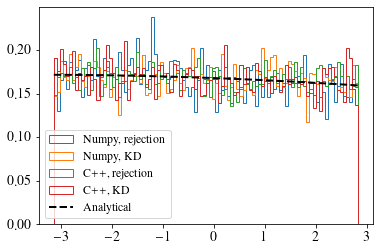

In [11]:
# Analytical result
X = np.linspace(x_min, x_max, 100)
TG = tmg.TruncatedGaussian1DPDF(X, mu, sig, x_min, x_max)

plt.hist(x_nr,int(np.sqrt(Nsampl)), density=True, histtype='step', label = 'Numpy, rejection')
plt.hist(x_n_KD,int(np.sqrt(Nsampl)), density=True, histtype='step', label = 'Numpy, KD')
plt.hist(x_cr,int(np.sqrt(Nsampl)), density=True, histtype='step', label = 'C++, rejection')
plt.hist(x_c_KD,int(np.sqrt(Nsampl)), density=True, histtype='step', label = 'C++, KD')
plt.plot(X,TG, color='k', ls='--', label = 'Analytical')
plt.legend()
plt.show()

## Testing the performance of different T1DG samplers

In [4]:
Ntests = 100
Nsampl = int(1e4)
times = []
accs = []

for _ in tqdm(range(Ntests)):
    x_min = rng.uniform(-5,5)
    x_max = x_min + rng.uniform(0,10)
    mu = rng.uniform(x_min*1.25,x_max*1.25)
    sig = 10.0**rng.uniform(0,1.5)
    
    tmg = TMG()

    tst = time.time()
    x_nr = tmg.T1DG_rejection_numpy(Nsampl, mu, sig, x_min, x_max)
    nr_acc = tmg.acceptance
    nr_t = time.time()-tst

    tst = time.time()
    x_n_KD = tmg.T1DG_KD_numpy(Nsampl, mu, sig, x_min, x_max)
    n_KD_t = time.time()-tst

    tst = time.time()
    x_cr = tmg.T1DG_rejection(Nsampl, mu, sig, x_min, x_max)
    cr_acc = tmg.acceptance
    cr_t = time.time()-tst

    tst = time.time()
    x_c_KD = tmg.T1DG_KD(Nsampl, mu, sig, x_min, x_max)
    c_KD_t = time.time()-tst
    
    times.append(np.array([nr_t, n_KD_t, cr_t, c_KD_t]))
    accs.append(np.array([nr_acc, cr_acc]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.04it/s]


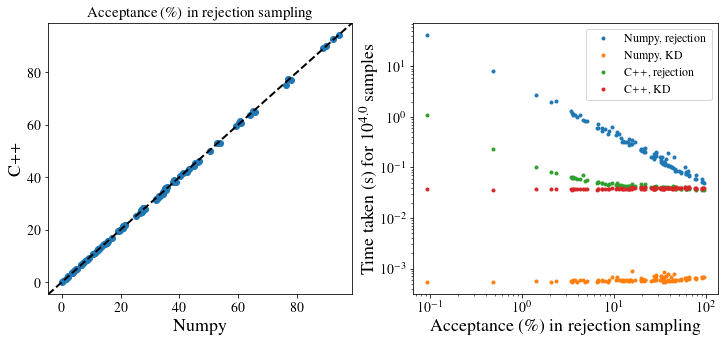

In [5]:
times = np.array(times)
accs = np.array(accs)
labels = ['Numpy, rejection', 'Numpy, KD', 'C++, rejection', 'C++, KD']

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter(accs[:,0]*100, accs[:,1]*100)
plt.title(r'Acceptance (\%) in rejection sampling')
plt.xlabel('Numpy')
plt.ylabel('C++')
plt.axline((50,50),slope=1,c='k',ls='--')

plt.subplot(122)
for t, label in zip(times.T, labels):
    plt.loglog(accs.mean(axis=1)*100, t, '.', label=label)
plt.xlabel(r'Acceptance (\%) in rejection sampling')
plt.ylabel(r'Time taken (s) for $10^{%.1f}$ samples' % np.log10(Nsampl))
plt.legend()
plt.show()

## Trucated Multidimensional Gaussian sampling with different methods

In [15]:
Ndim = 5
Nsampl = int(5e3)
x_min = rng.uniform(-50.0, 0.0, Ndim)
x_max = x_min + rng.uniform(0.0, 100.0, Ndim)
mu = np.array([rng.uniform(x_min[i],x_max[i]) for i in range(Ndim)])

cov = 10.0**rng.uniform(-Ndim,1.5,(Ndim,Ndim))
cov *= np.sign(rng.uniform(0.0, 1.0, (Ndim,Ndim)) - 0.5)
cov = cov @ cov.T

tmg = TMG()

tst = time.time()
x_nr = tmg.TMG_rejection_numpy(Nsampl, mu, cov, x_min, x_max, showprogress=True)
acc = tmg.acceptance
print('Numpy rejection sampling: time taken = %.3f s, Acceptance rate = %.2f%%' % (time.time()-tst, acc * 100.0))

tst = time.time()
x_n_KD = tmg.TMG_KDGibbs_numpy(Nsampl, mu, cov, x_min, x_max)
print('Numpy KD-Gibbs sampling: time taken = %.3f s' % (time.time()-tst))

tst = time.time()
x_cr = tmg.TMG_rejection(Nsampl, mu, cov, x_min, x_max)
acc = tmg.acceptance
print('C++ rejection sampling: time taken = %.3f s, Acceptance rate = %.2f%%' % (time.time()-tst, acc * 100.0))

tst = time.time()
x_c_KD = tmg.TMG_KDGibbs(Nsampl, mu, cov, x_min, x_max)
print('C++ KD-Gibbs sampling: time taken = %.3f s' % (time.time()-tst))

Sampled: 4999, acceptance: 51.06 %

Numpy rejection sampling: time taken = 1.365 s, Acceptance rate = 51.06%
Numpy KD-Gibbs sampling: time taken = 1.825 s
C++ rejection sampling: time taken = 0.087 s, Acceptance rate = 50.51%
C++ KD-Gibbs sampling: time taken = 0.163 s


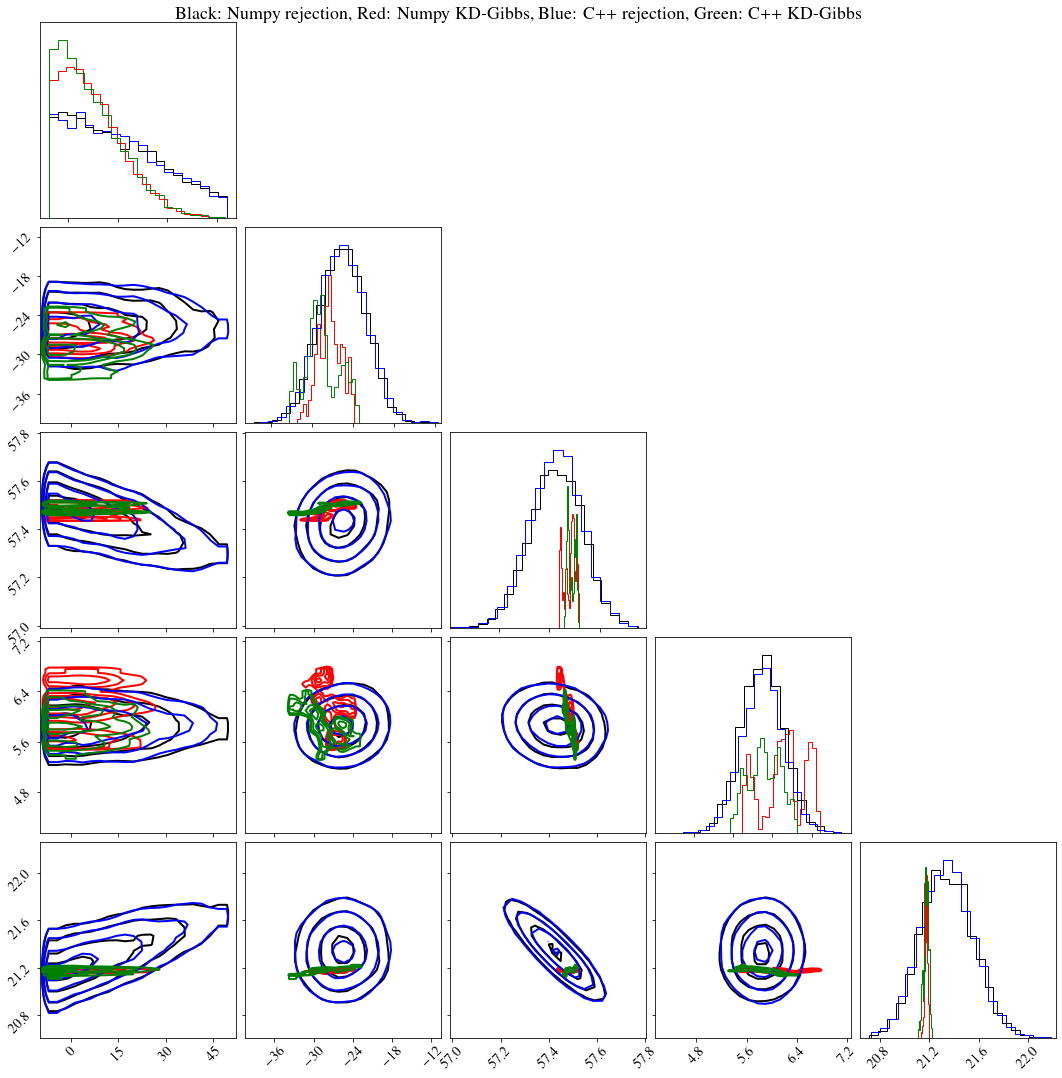

In [16]:
fig = plt.figure(figsize=(16,16))
corner.corner(x_nr, fig=fig, smooth=0.9, plot_datapoints=False, fill_contours=False, plot_density=False, no_fill_contours=True)
corner.corner(x_n_KD, color='r', fig=fig, smooth=0.9, plot_datapoints=False, fill_contours=False, plot_density=False, no_fill_contours=True)
corner.corner(x_cr, color='b', fig=fig, smooth=0.9, plot_datapoints=False, fill_contours=False, plot_density=False, no_fill_contours=True)
corner.corner(x_c_KD, color='g', fig=fig, smooth=0.9, plot_datapoints=False, fill_contours=False, plot_density=False, no_fill_contours=True)
plt.suptitle('Black: Numpy rejection, Red: Numpy KD-Gibbs, Blue: C++ rejection, Green: C++ KD-Gibbs')
plt.show()

# Conclusions
- For 1D sampling, all four methods are reliable
- Numpy based Kotecha-Djuric method is the fastest for sampling from a truncated gaussian

- For multivariate normal sampling, KD-Gibbs method (the way I have implemented it) is not reliable
- C++ based rejection sampling is the fastest and most reliable method for sampling from a truncated multidimensional gaussian